# Cluster Analysis of Tweets
## Cluster Analysis Details
Here we are trying to uncover some underlying structure to the tweets we have collected so far. We will first try to perform a cluster analysis to the tweets to see if the tweets will group into clusters that we can exploit when trying to label data. We start by describing the problem:

We are given an input dataset $\mathbf{X} = [x_1, \dots, x_k]$, where $x_i \in \mathbb{R}^d$. We want to find a dictionary $\mathbf{D} \in \mathbb{R}^{d x n}$: $\mathbf{D} = [d_1, \dots, d_n]$ and a representation $\mathbf{R} = [r_1, ..., r_k], r_i \in \mathbb{R}^n$ s.t. both $||\mathbf{X} - \mathbf{DR}||^2_F$ is minimized and the representations $r_i$ are sparse enough. This has the optimization problem:

${argmin}_{D\in C, r_i \in \mathbb{R}^n} \sum_{i=1}^{k} ||x_i - Dr_i||^2_2 + \lambda ||r_i||_0$, where $C \equiv \{D\in \mathbb{R}^{d x n}: ||d_i||_2 \leq 1, \forall i \in 1, \dots, n\}, \lambda >0$

$C$ is required to constrain $\mathbf{D}$ so that its atoms would not reach arbitrarily high values allowing for arbitrarily low (but non-zero) values of $r_{i}$. $\lambda$  controls the trade off between the sparsity and the minimization error. We usually use the $\ell_1$ instead of the $\ell_0$ norm instead in order to maintain convexity of the problem. In this case, we are dealing with an __overcomplete dictionary__ since the dimension of the representations of the strings $n$ is larger than the input data's dimension $d$. An overcomplete dictionary which allows for sparse representation of signal can be a famous transform matrix (wavelets transform, fourier transform) or it can be formulated so that its elements are changed in such a way that it sparsely represents the given signal in a best way. Learned dictionaries are capable of giving sparser solutions as compared to predefined transform matrices.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import glob
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import string
import re
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Making a list directory of all the tweets we have collected
files_0 = glob.glob('./datasets/water_tweets/gathered_water/*.csv')
water1_tweets = pd.read_csv('./datasets/water_tweets/water1.csv', encoding = 'ISO-8859-1', delimiter = ',')

# loading JSON files
from pandas.io.json import json_normalize
with open('datasets/water_tweets/gathered_water/water8.json', 'r', encoding="utf-8") as json_file:
    water_json_1 = pd.read_json('datasets/water_tweets/gathered_water/water8.json', typ='object', orient='columns')
    water_json_1 = pd.io.json.json_normalize(water_json_1)
    water_json_1 = water_json_1[['text', 'timestamp']]

with open('datasets/water_tweets/gathered_water/water9_drought.json', 'r', encoding = 'utf-8') as json_file:
    water_json_2 = pd.read_json('datasets/water_tweets/gathered_water/water9_drought.json', typ='object', orient='columns')
    water_json_2 = pd.io.json.json_normalize(water_json_2)
    water_json_2 = water_json_2[['text', 'timestamp']]

water_jsons = pd.concat([water_json_1, water_json_2])
water_jsons.columns = ['text', 'date']
water_jsons['retweet_count'] = np.nan
water_jsons['category'] = np.nan
water_jsons['tweet_id'] = np.nan
water_jsons = water_jsons[['category', 'date', 'text', 'retweet_count', 'tweet_id']]

# Loading uniformly formatted pulled tweets
water_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_0])
water_csvs = pd.concat([water1_tweets, water_csvs, water_jsons])
water_csvs = water_csvs[['category', 'text']]
water_csvs = water_csvs[water_csvs['text'] != 'text']
water_csvs = water_csvs[water_csvs['category'] != 'pcb']
water_csvs = water_csvs[water_csvs['category'] != 'benzene']
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
water_csvs['text'] =  water_csvs['text'].astype(str)
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
water_csvs = water_csvs.iloc[:, 1:]
#all_csvs.columns = ['category', 'date', 'tweet', 'retweet_count', 'tweet_id']
print(len(water_csvs))

water_csvs.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



99205


,category,text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...
2,flash flood,So the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod..."
4,flash flood,"They might not call it a #climatedebate, but c..."


## Clean the Text

In [4]:
# Text cleaner found on github: https://github.com/martinpella/twitter-airlines/blob/master/utils.py
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bhrs\b', 'hours', text)
        text = re.sub(r'\baa\b', 'a', text)
        text = re.sub(r'\bflightr\b', 'flight', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\bhr\b', 'hour', text)
        text = re.sub(r'\bthru\b', 'through', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\btix\b', 'fix', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\bflightd\b', 'flighted', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bpls\b', 'please', text)
        text = re.sub(r'\bfyi\b', 'for your information', text)
        
        text = re.sub(r'\bheyyyy\b', 'hey', text)
        text = re.sub(r'\bguyyyys\b', 'guys', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\bdm\b', 'direct message', text)
        text = re.sub(r'\bcudtomers\b', 'customers', text)
        text = re.sub(r'\bwtf\b', 'what the fuck', text)
        text = re.sub(r'\biphone\b', 'phone', text)
        text = re.sub(r'\bmins\b', 'minutes', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\bfeb\b', 'february', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\btill\b', 'until', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\btho\b', 'though', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [5]:
# Clean the text
tc = TextCleaner()
water_csvs['cleaned_text'] = tc.transform(water_csvs['text'])
water_csvs.head()

,category,text,cleaned_text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...
2,flash flood,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...
4,flash flood,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...


In [6]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

water_csvs['tokenized'] = water_csvs['cleaned_text'].apply(lambda row: tokenize(row))
water_csvs.head()

,category,text,cleaned_text,tokenized
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,"[its, cwazy, mom, tiwed, of, seeing, flash, fl..."
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...,"[passes, to, flash, flood, water, park, in, ba..."
2,flash flood,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,"[so, the, maintenance, men, at, my, apartment,..."
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...,"[issued, floodflash, flood, products, in, may,..."
4,flash flood,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...,"[they, might, not, call, it, a, climatedebate,..."


In [7]:
water_csvs = water_csvs.drop_duplicates(subset = ['cleaned_text']).reset_index()
water_csvs = water_csvs.iloc[:, 1:]
print(len(water_csvs))
water_csvs.head()

85744


,category,text,cleaned_text,tokenized
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,"[its, cwazy, mom, tiwed, of, seeing, flash, fl..."
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...,"[passes, to, flash, flood, water, park, in, ba..."
2,flash flood,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,"[so, the, maintenance, men, at, my, apartment,..."
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...,"[issued, floodflash, flood, products, in, may,..."
4,flash flood,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...,"[they, might, not, call, it, a, climatedebate,..."


In [8]:
from nltk.corpus import stopwords

import collections
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

water_csvs['tokenized'] = water_csvs['tokenized'].apply(lambda row: remove_stopwords(row))
print(water_csvs.head())
vocab_counter = collections.Counter()

      category                                               text  \
0  flash flood  @LeslieWalden6 @MookieTheBrave @AngusMcPussPus...   
1  flash flood  4 PASSES to FLASH FLOOD WATER PARK in Battle C...   
2  flash flood  So the maintenance men at my apartment complex...   
3  flash flood  .@NWStulsa issued 1,530 flood/flash flood prod...   
4  flash flood  They might not call it a #climatedebate, but c...   

                                        cleaned_text  \
0  its cwazy mom tiwed of seeing flash flood warn...   
1  passes to flash flood water park in battle cre...   
2  so the maintenance men at my apartment complex...   
3  issued floodflash flood products in may alone ...   
4  they might not call it a climatedebate but con...   

                                           tokenized  
0  [cwazy, mom, tiwed, seeing, flash, flood, warn...  
1  [passes, flash, flood, water, park, battle, cr...  
2  [maintenance, men, apartment, complex, leaf, b...  
3  [issued, floodflash, floo

In [9]:
tokens = np.array(water_csvs['tokenized']).reshape(-1, 1)
words = []
for i in range(len(tokens)):
    tweet = tokens[i]
    for j in range(len(tweet)):
        new_word = tweet[j]
        words.append(new_word)

print(type(words))
indivs = []
for tweet in range(len(words)):
    t = words[tweet]
    for j in range(len(t)):
        indivs.append(t[j])
indivs[:2]

<class 'list'>


['cwazy', 'mom']

## Build a Dictionary

In [10]:
from collections import Counter

vocabulary_size = 25000

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
# [("<UNK>", None)] + [("<HST>", None)] + [("<EMT>", None)] + [("<URL>", None)] + [("<THDL>", None)] +
vocabulary = Counter(indivs).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in indivs])
print(len(vocabulary))
#print(len(data))

24999


## Algorithm Used: K-means
Using the vector representations of the tweets we have gathered, we can perform k-means clustering of the tweets we have gathered. We will perform tf-idf vectorization of the tweets to aid the clustering algorithm, which calculates how often a word appears in a tweet and then counts its inverse document frequency to standardize the count. The standard k-means in this case is carried out as follows:

Given an initial-set of *k* means $m_1^{(1)}, \dots, m_k^{(1)}$, we alternate between:

__Assignment step:__ Assign each observation to the cluster whose mean has the least squared Euclidean distance, this is intuitively the "nearest" mean. (Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means).

$S_i^{(t)} = \{x_p: ||x_p - m_i^{(t)}||^2 \leq ||x_p - m_j^{(t)}||^2, \forall j \in 1, \dots, k\}$, where each $x_p$ is assigned to one $S^{(t)}$, even it can be assigned to two or more of them.

__Update step:__ Calculate the new means (centroids) of the observations of the new clusters:

$m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|}\sum_{x_j \in S_i^{(t)}} x_j$

The algorithm has converged when the assignments no longer change. The algorithm does not guarantee to find the optimum.

In [11]:
# tf-idf vectorization
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first')
water_tweets = np.array(water_csvs.text)

# If we get labeled data, we would use train_test_split to test out our model
#from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(water_tweets, test_size = 0.20, random_state = 42)

from sklearn.feature_extraction.text import TfidfVectorizer
# We used the vocabulary formulation from the embedding formed from the autoenconder_for_tweets.ipynb
vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', vocabulary = vocabulary)

# tf-idf vectorization of the training set
X_tfidf = vectorizer.fit_transform(water_tweets)
#print(vectorizer.get_feature_names())
print(X_tfidf.shape)

(85744, 24999)


In [12]:
# Clustering of water tweets
from sklearn import cluster
from sklearn import metrics

print(type(X_tfidf))
print(water_tweets[:5])
print(X_tfidf[:5])

<class 'scipy.sparse.csr.csr_matrix'>
["@LeslieWalden6 @MookieTheBrave @AngusMcPussPuss @AngelaStillwell @cat_samson @arkantart @Biscuit_Meow @duchess_meow @TobiasandJasper @goodman_carina It's cwazy!! Mom tiwed of seeing flash flood warnings fwom The Weather Channel pop up on her phone evewyday. She appweciates the warning, but she knows which aweas are pwone to flooding.ð\x9f\x98¼ð\x9f\x98¼"
 '4 PASSES to FLASH FLOOD WATER PARK in Battle Creek, MICHIGAN - 2019 season!!! $12.00 | #WaterparkTickets | https://t.co/tIumVg5T0d Grab Your Tickets https://t.co/UQNz5zZ7vC'
 'So the maintenance men at my apartment complex are leaf blowing during a flash flood warning... https://t.co/YkWkVzTvSy'
 '.@NWStulsa issued 1,530 flood/flash flood products in May 2019 alone!  Includes new warnings/advisories + all follow up statements #okwx #arwx https://t.co/3M9GfJyuez'
 'They might not call it a #climatedebate, but considering that the venue where 20 Democrats are meeting in Miami this week was once i

Fit 25 clusters
Fit 50 clusters
Fit 75 clusters
Fit 100 clusters
Fit 125 clusters
Fit 150 clusters
79996.50072458165 [99]


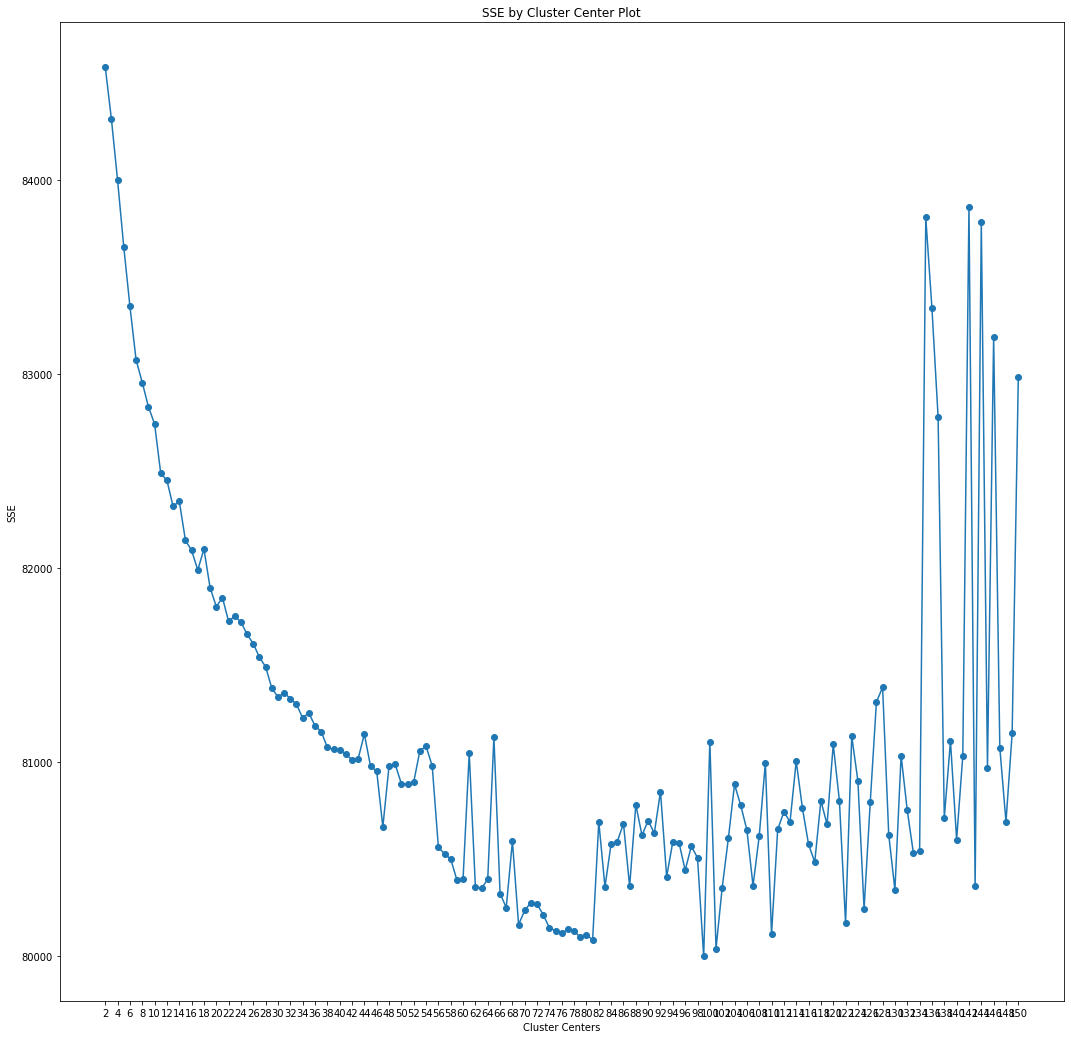

In [13]:
# Cluster analysis 
def find_optimal_clusters(data, min_k, max_k, num):
    iters = np.linspace(min_k, max_k, num = num).astype(int)
    
    sse = []
    for k in range(len(iters)):
        sse.append(cluster.MiniBatchKMeans(n_clusters = iters[k], init_size = 1024, batch_size = 2048, random_state = 42,
                                          reassignment_ratio = 0.01).fit(data).inertia_)
        if iters[k] % 25 == 0:
            print('Fit {} clusters'.format(iters[k].astype(int)))
            
    idx = np.where(sse == np.amin(sse))
    print(np.amin(sse), iters[idx])
          
    f, ax = plt.subplots(1, 1, figsize = (18, 18))
    #for n, label in enumerate(ax.xaxis.get_ticklabels()):
      #  if n % 10 != 0:
     #       label.set_visible(False)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters[np.where(iters % 2 == 0)])
    ax.set_xticklabels(iters[np.where(iters % 2 == 0)])
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 2, 150, 149)

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [16]:
# *Almost* the best amount of clusters given the elbow function
# evaluation shown above using mini-batch k-means
clusters = cluster.MiniBatchKMeans(n_clusters=45, init_size=1024, batch_size=2048, random_state=42).fit_predict(X_tfidf)

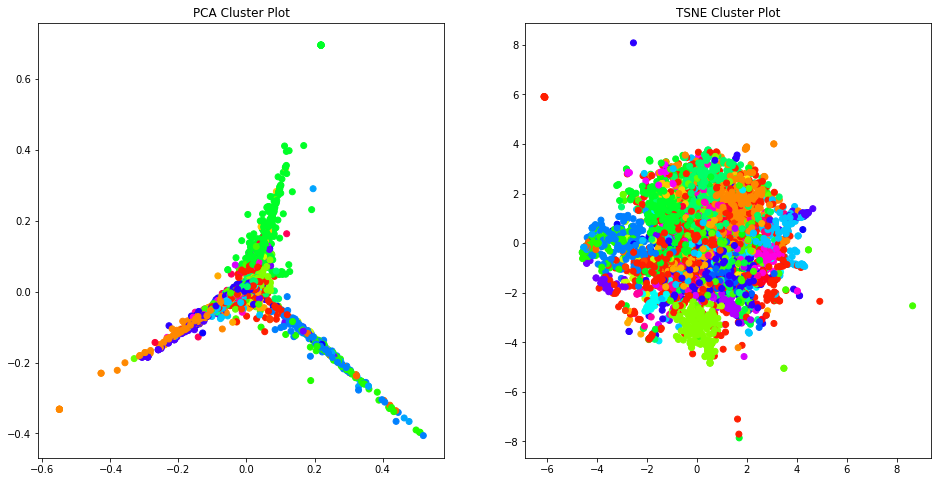

In [17]:
# Plotting the cluster analysis of gathered water tweets
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=10000, replace=False)
    
    pca = PCA(n_components=0.95).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=0.95).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=5000, replace=False)
    label_subset = labels[max_items]
    label_subset = [mpl.cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_tfidf, clusters)

Functions are similar to the ones found from Kaggle at this link: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans/comments

In [18]:
# What are the most common keywords in these clusters
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_tfidf, clusters, vectorizer.get_feature_names(), 30)



Cluster 0
parent,salaries,description,dos,tension,irrigate,supposedly,footing,tenure,diploma,tenders,advertising,adverse,tyre,roofs,brook,hydrocarbons,shld,firing,inaction,bpa,nova,water,drought,start,real,scarcity,shame,news,reporting

Cluster 1
day,right,good,today,chemical,public,access,help,know,beach,watermanagement,safe,world,need,com,health,drought,food,new,clean,like,flashflood,people,pipe,leak,coli,drinking,sanitation,contamination,water

Cluster 2
bacteria,today,lake,level,park,left,new,change,coli,air,temperatures,waste,time,risk,low,people,prices,like,quality,contamination,drinking,drought,management,school,pollution,dry,lead,levels,water,high

Cluster 3
post,hwo,national,service,new,okx,nj,including,aug,pa,effect,alert,wv,oh,weather,ny,county,august,continues,issues,jul,nws,issued,watch,pm,warning,july,flash,flood,edt

Cluster 4
know,business,think,better,make,ya,sure,love,lot,lol,im,stop,hope,bottle,lots,really,minding,need,people,today,good,start,clean,drink,eating,day,

| Cluster | Use? | Cluster | Use? |
| ------- | ---- | ------- | ---- |
| 0 | N | 23 | N |
| 1 | ? | 24 | N |
| 2 | Y | 25 | Y |
| 3 | Y | 26 | Y |
| 4 | N | 27 | N |
| 5 | ? | 28 | N |
| 6 | N | 29 | Y |
| 7 | N | 30 | ? |
| 8 | N | 31 | N |
| 9 | Y | 32 | N |
| 10 | N | 33 | Y |
| 11 | Y | 34 | N |
| 12 | N | 35 | N |
| 13 | N | 36 | Y |
| 14 | Y | 37 | ? |
| 15 | N | 38 | N |
| 16 | ? | 39 | N |
| 17 | N | 40 | ? |
| 18 | N | 41 | N |
| 19 | Y | 42 | Y |
| 20 | ? | 43 | N |
| 21 | ? | 44 | N |
| 22 | Y |

In [19]:
print(len(clusters))

85744


In [20]:
t_c = {'text': water_tweets, 'cleaned_text': np.array(water_csvs.cleaned_text), 'cluster': clusters}
water_tweet_cluster = pd.DataFrame(data = t_c)
water_tweet_cluster.head(25)

,text,cleaned_text,cluster
0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,14
1,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...,26
2,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,14
3,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...,26
4,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...,26
5,*Flash Flood Warnings*\n*Extreme weather advis...,flash flood warnings extreme weather advisorie...,30
6,More info: https://t.co/HtkH9Or0b3 https://t.c...,more info,1
7,Very Dangerous Flash Flood | Natural Disaster ...,very dangerous flash flood natural disaster pu...,26
8,@Rnikz_ @JoahanYT he dead ass said #DareToAchi...,he dead ass said daretoachive after sending pr...,26
9,The 20 Democrats will meet this week in a Miam...,the democrats will meet this week in a miami p...,26


In [22]:
cluster_count = water_tweet_cluster.groupby('cluster').count().reset_index()
cluster_count = cluster_count.iloc[:, 1]
cluster_count.columns = ['count']
cluster_count

0         1
1     15865
2      1064
3       414
4      6485
5      5411
6       327
7       523
8         3
9       413
10      238
11     3920
12     1959
13     3100
14     2156
15      312
16     8575
17     1420
18     6750
19      505
20        2
21        1
22     1360
23      765
24     4231
25      236
26     2539
27     1572
28       22
29       20
30      637
31     5671
32     1096
33      299
34        1
35     1262
36      709
37      540
38     1325
39      854
40     1290
41      298
42      405
43      623
44      545
Name: text, dtype: int64

In [26]:
prob_yes = water_tweet_cluster.loc[(water_tweet_cluster.cluster == 2) | (water_tweet_cluster.cluster == 3) | \
                         (water_tweet_cluster.cluster == 9) | (water_tweet_cluster.cluster == 11) | \
                         (water_tweet_cluster.cluster == 14) | (water_tweet_cluster.cluster == 19) | \
                         (water_tweet_cluster.cluster == 22) | (water_tweet_cluster.cluster == 25) | \
                         (water_tweet_cluster.cluster == 26) | (water_tweet_cluster.cluster == 29) | \
                         (water_tweet_cluster.cluster == 33) | (water_tweet_cluster.cluster == 36) | \
                         (water_tweet_cluster.cluster == 42)]
prob_yes.head(10)

,text,cleaned_text,cluster
0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,14
1,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...,26
2,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,14
3,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...,26
4,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...,26
7,Very Dangerous Flash Flood | Natural Disaster ...,very dangerous flash flood natural disaster pu...,26
8,@Rnikz_ @JoahanYT he dead ass said #DareToAchi...,he dead ass said daretoachive after sending pr...,26
9,The 20 Democrats will meet this week in a Miam...,the democrats will meet this week in a miami p...,26
11,Please keep us in your prayers as we will be r...,please keep us in your prayers as we will be r...,26
12,Flash flood warning issued for Hawaii as freak...,flash flood warning issued for hawaii as freak...,14


In [74]:
dict_of_clusters = {k: v for k, v in water_tweet_cluster.groupby('cluster')}

## Sub-cluster Analysis Used to Generate Relevant Data

In [62]:
useful_clusters = prob_yes.cluster.unique()
print(useful_clusters)

dataframes = []
for i in useful_clusters:
    cluster__i__ = prob_yes[prob_yes['cluster'] == i].reset_index()
    dataframes.append(cluster__i__)
print(dataframes)

[14 26  9 19 36  2 42 11 33 22  3 25 29]
[      index                                               text  \
0         0  @LeslieWalden6 @MookieTheBrave @AngusMcPussPus...   
1         2  So the maintenance men at my apartment complex...   
2        12  Flash flood warning issued for Hawaii as freak...   
3        17  Flash flood warning issued for Hawaii as freak...   
4        21  Students today are facing many crises: But of ...   
...     ...                                                ...   
2151  80782  NWS Alert&gt  Flash Flood Warning: Affected Lo...   
2152  80783  Flash Flood Warning including Alzada MT, Hammo...   
2153  80784  BYZ issues Flash Flood Warning for Carter [MT]...   
2154  81607  there's a flood warning i'm scared, it's gonna...   
2155  84595  Heh. After months of drought, now we're in a f...   

                                           cleaned_text  cluster  
0     its cwazy mom tiwed of seeing flash flood warn...       14  
1     so the maintenance men at

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
1864.4888549292073 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
2345.271181763578 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
346.2532279584186 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
456.1210842598808 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
640.2538940003429 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
1007.2023527072171 [19]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
365.42783160410465 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
3652.328033519473 [19]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
217.83208002249842 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
1215.625102069894 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
254.6643207529764 [20]
Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit

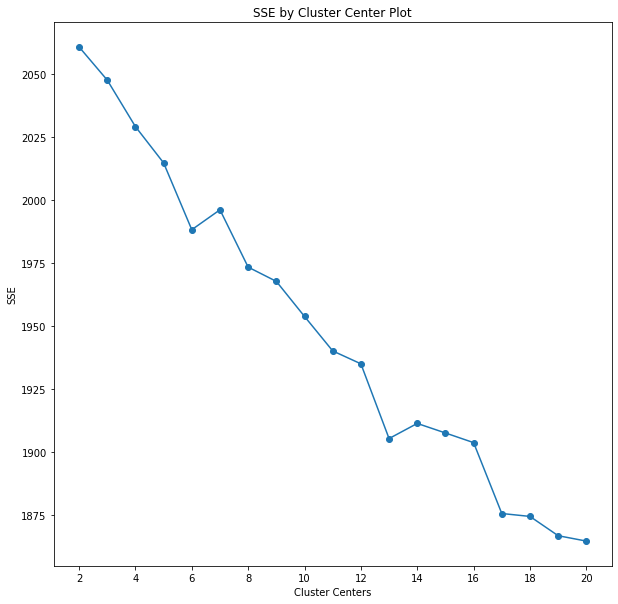

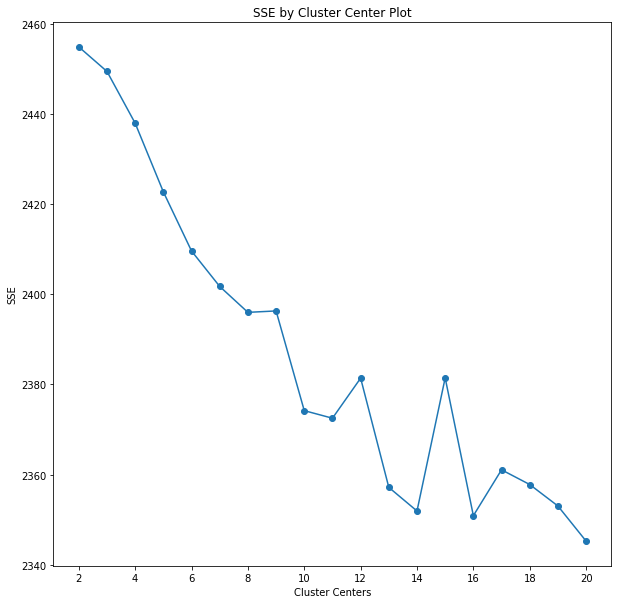

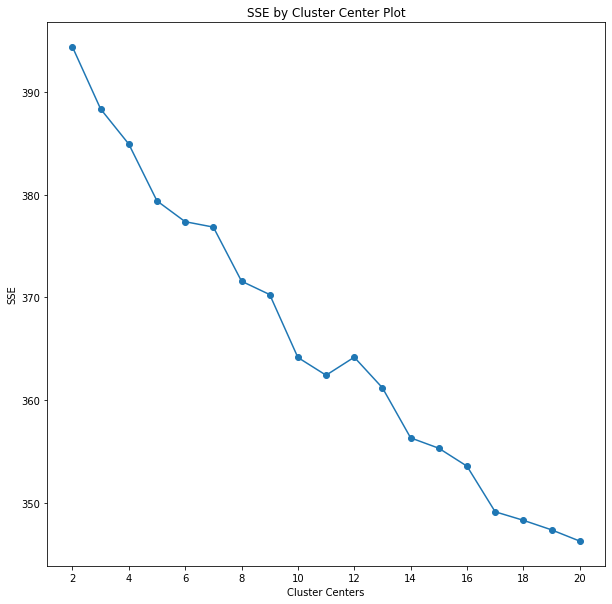

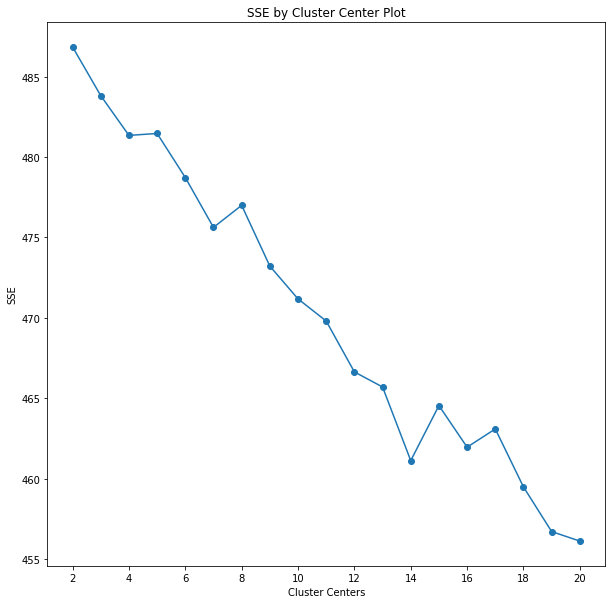

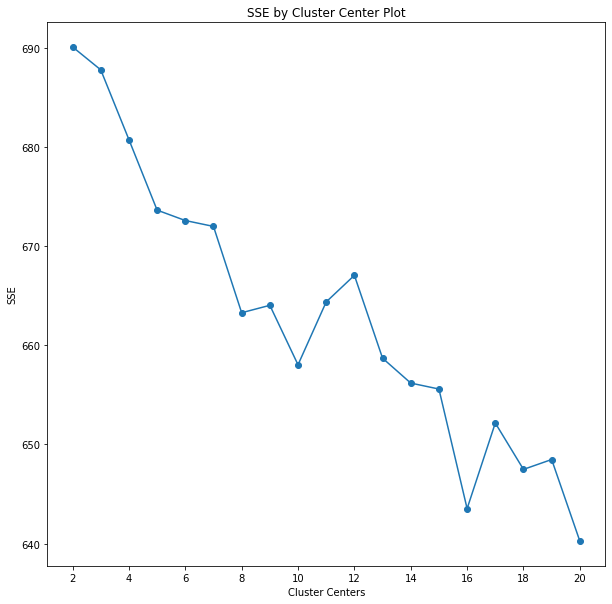

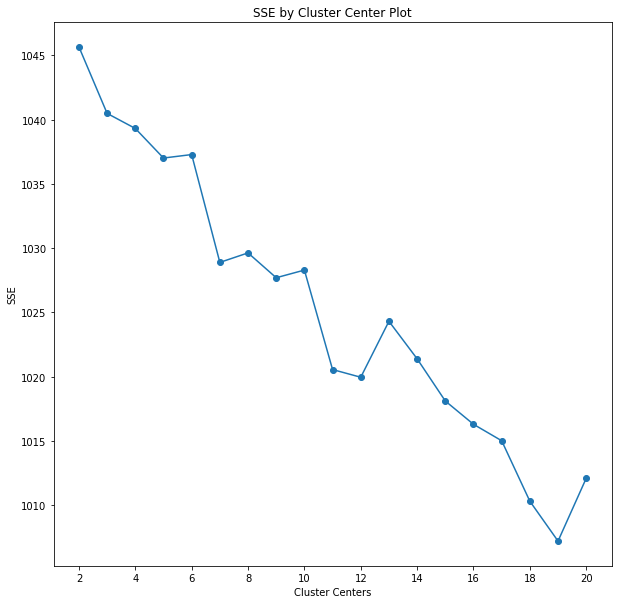

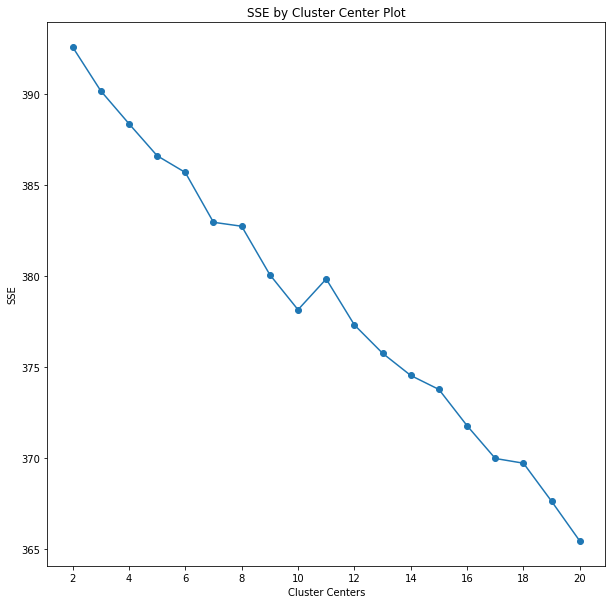

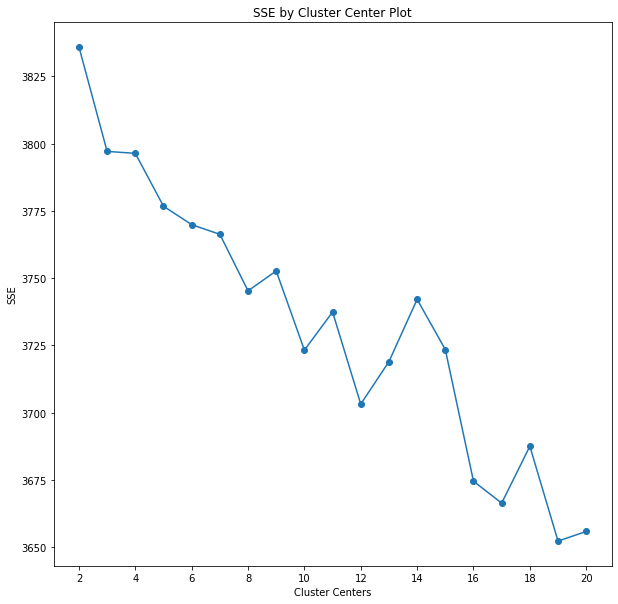

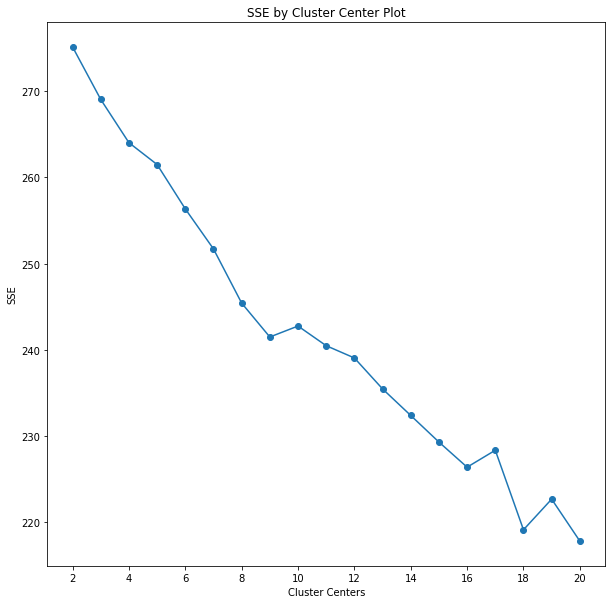

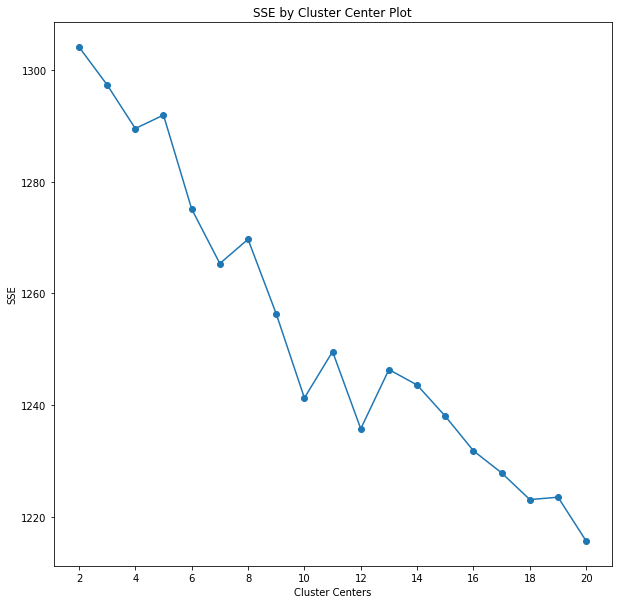

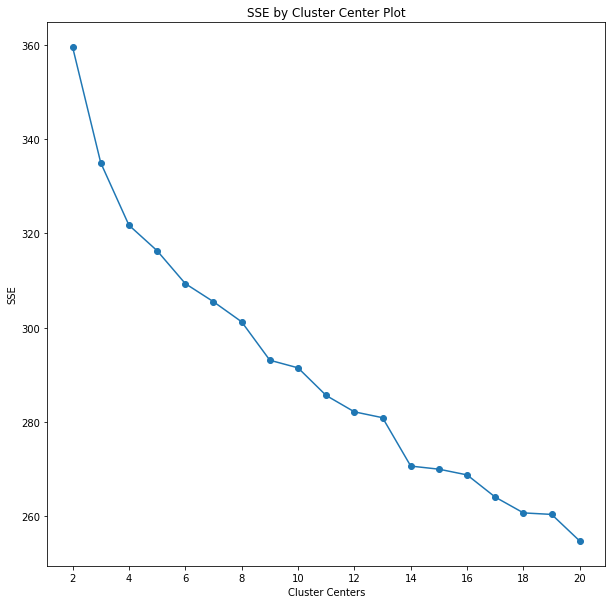

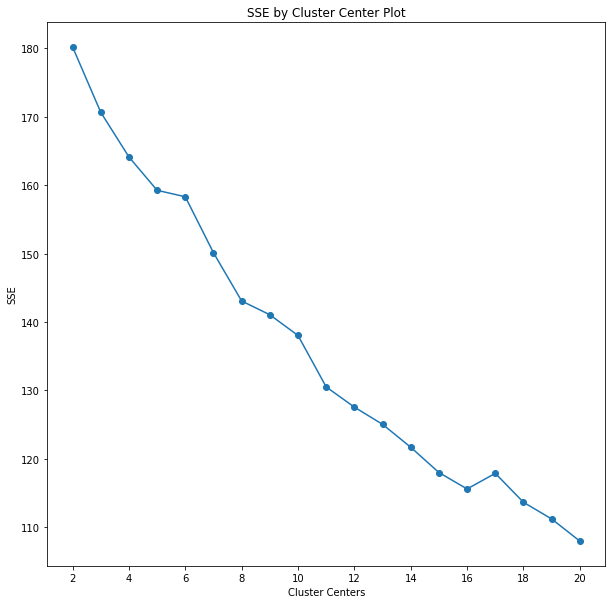

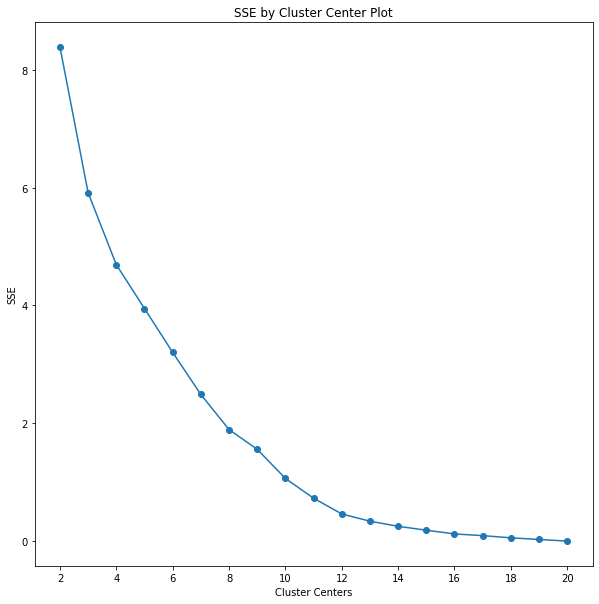

In [68]:
# sub-cluster analysis
def find_optimal_clusters_small(data, min_k, max_k, num):
    iters = np.linspace(min_k, max_k, num = num).astype(int)
    
    sse = []
    for k in range(len(iters)):
        sse.append(cluster.MiniBatchKMeans(n_clusters = iters[k], random_state = 42,
                                          reassignment_ratio = 0.01).fit(data).inertia_)
        if iters[k] % 5 == 0:
            print('Fit {} clusters'.format(iters[k].astype(int)))
            
    idx = np.where(sse == np.amin(sse))
    print(np.amin(sse), iters[idx])
          
    f, ax = plt.subplots(1, 1, figsize = (10, 10))
    #for n, label in enumerate(ax.xaxis.get_ticklabels()):
      #  if n % 10 != 0:
     #       label.set_visible(False)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters[np.where(iters % 2 == 0)])
    ax.set_xticklabels(iters[np.where(iters % 2 == 0)])
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

for i in range(len(dataframes)):
    tfidf = vectorizer.fit_transform(dataframes[i]['cleaned_text'])
    find_optimal_clusters_small(tfidf, 2, 20, 19)

In [69]:
# putting the subclusters into the new dataframes
clusters_0 = cluster.KMeans(n_clusters = 13, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[0]['cleaned_text'])).labels_
clusters_1 = cluster.KMeans(n_clusters = 8, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[1]['cleaned_text'])).labels_
clusters_2 = cluster.KMeans(n_clusters = 11, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[2]['cleaned_text'])).labels_
clusters_3 = cluster.KMeans(n_clusters = 14, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[3]['cleaned_text'])).labels_
clusters_4 = cluster.KMeans(n_clusters = 10, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[4]['cleaned_text'])).labels_
clusters_5 = cluster.KMeans(n_clusters = 7, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[5]['cleaned_text'])).labels_
clusters_6 = cluster.KMeans(n_clusters = 10, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[6]['cleaned_text'])).labels_
clusters_7 = cluster.KMeans(n_clusters = 4, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[7]['cleaned_text'])).labels_
clusters_8 = cluster.KMeans(n_clusters = 9, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[8]['cleaned_text'])).labels_
clusters_9 = cluster.KMeans(n_clusters = 10, n_init = 25, random_state = 42, max_iter = 500).\
             fit(vectorizer.fit_transform(dataframes[9]['cleaned_text'])).labels_
clusters_10 = cluster.KMeans(n_clusters = 5, n_init = 25, random_state = 42, max_iter = 500).\
              fit(vectorizer.fit_transform(dataframes[10]['cleaned_text'])).labels_
clusters_11 = cluster.KMeans(n_clusters = 16, n_init = 25, random_state = 42, max_iter = 500).\
              fit(vectorizer.fit_transform(dataframes[11]['cleaned_text'])).labels_
clusters_12 = cluster.KMeans(n_clusters = 11, n_init = 25, random_state = 42, max_iter = 500).\
              fit(vectorizer.fit_transform(dataframes[12]['cleaned_text'])).labels_

### Figure out which subclusters are useful

In [70]:
dataframes[0]['subcluster'] = clusters_0
dataframes[1]['subcluster'] = clusters_1
dataframes[2]['subcluster'] = clusters_2
dataframes[3]['subcluster'] = clusters_3
dataframes[4]['subcluster'] = clusters_4
dataframes[5]['subcluster'] = clusters_5
dataframes[6]['subcluster'] = clusters_6
dataframes[7]['subcluster'] = clusters_7
dataframes[8]['subcluster'] = clusters_8
dataframes[9]['subcluster'] = clusters_9
dataframes[10]['subcluster'] = clusters_10
dataframes[11]['subcluster'] = clusters_11
dataframes[12]['subcluster'] = clusters_12

In [71]:
dataframes[0]

,index,text,cleaned_text,cluster,tfidf,subcluster
0,0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
1,2,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
2,12,Flash flood warning issued for Hawaii as freak...,flash flood warning issued for hawaii as freak...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
3,17,Flash flood warning issued for Hawaii as freak...,flash flood warning issued for hawaii as freak...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
4,21,Students today are facing many crises: But of ...,students today are facing many crises but of c...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
...,...,...,...,...,...,...
2151,80782,NWS Alert&gt Flash Flood Warning: Affected Lo...,nws alertgt flash flood warning affected locat...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",11
2152,80783,"Flash Flood Warning including Alzada MT, Hammo...",flash flood warning including alzada mt hammon...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3
2153,80784,BYZ issues Flash Flood Warning for Carter [MT]...,byz issues flash flood warning for carter mt u...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",4
2154,81607,"there's a flood warning i'm scared, it's gonna...",theres a flood warning im scared its gonna rai...,14,"(0, 2210)\t0.3637559609744274\n (0, 2138)\t...",3


In [73]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        

for i in range(len(dataframes)):
    print('These are the top keywords for {} cluster'.format(i))
    get_top_keywords(vectorizer.fit_transform(dataframes[i]['cleaned_text']), np.array(dataframes[i]['subcluster']),
                     vectorizer.get_feature_names(), 20)

These are the top keywords for 0 cluster

Cluster 0
aug,updates,ron,roberts,weathernow,zoom,county,continues,warning,flood,santa,fe,flash,bernalillo,colfax,sandoval,pm,abq,mdt,nm

Cluster 1
city,pm,deweyville,sabine,nws,extends,affecting,mo,warning,aug,flood,rivers,following,near,cdt,continues,notice,missouri,august,river

Cluster 2
national,forrest,service,sunday,latest,mswx,effect,wx,wednesday,saturday,nws,weather,monday,issued,warning,flood,flash,pm,alert,county

Cluster 3
fallen,morning,expires,flooded,weather,baltimore,heavy,dont,got,county,flooding,areas,effect,issued,pm,area,rain,flash,flood,warning

Cluster 4
ut,county,mt,ne,pitkin,huerfano,pub,sd,delta,custer,gjt,warning,flood,including,continues,flash,issues,jul,pm,mdt

Cluster 5
madison,collins,lee,holmes,pontotoc,jasper,cancels,jones,covington,including,pm,issues,warning,flood,flash,continues,jul,jan,cdt,ms

Cluster 6
paz,tucson,mohave,issues,psr,expires,twc,pima,yavapai,jul,including,warning,flood,flash,fgz,continues,gila,


Cluster 0
springst,published,analysis,abcclimatewatch,abares,mention,murraydarlingbasin,auspol,australia,high,water,climatechange,drive,change,climate,driving,drought,basin,murraydarling,prices

Cluster 1
surf,threat,reports,area,amounts,local,barry,officials,flood,rain,heavy,flash,homes,highland,flooding,park,high,water,levels,lead

Cluster 2
vancouver,river,people,country,lake,contamination,swimmers,lead,health,groundwater,coli,beaches,record,beach,closed,ecoli,water,high,levels,drinking

Cluster 3
food,risk,lake,low,use,air,people,new,like,bacteria,levels,quality,time,waste,contamination,drought,management,pollution,high,water

Cluster 4
sfi,drought,said,young,city,shine,like,million,convention,lead,students,clubs,nwscswas,nwsc,mbarara,drinking,sanitation,high,water,school

Cluster 5
end,day,great,sure,rain,days,leaving,make,load,need,heat,today,skin,like,im,leave,dont,left,high,dry

Cluster 6
tonnes,pressure,told,displaced,triggers,major,aircraft,highpressure,ruptured,allston,neck

adverse,tyre,domes,brook,hydrocarbons,shld,lac,inaction,firing,roofs,mn,winona,flood,flash,warning,wabasha,arx,wi,buffalo,expires


## Relevant List:
__Using my best judgment from the most common keywords for each subcluster, these are the cluster-subcluster that contain relevant tweets. If we start picking up irrelevant stuff, this is where we will hope our active learning strategy will take over.__

| Dataframe | Useful Subclusters |
| --------- | ------------------ |
| 0 | All |
| 1 | All |
| 2 | 0, 1, 5, 6, 7, 8, 9, 10 |
| 3 | 0?, 1?, 2?, 5?, 7, 8, 9, 10, 11 |
| 4 | 1?, 4?, 5?, 7? |
| 5 | 0, 1, 2, 3 |
| 6 | None? |
| 7 | 0, 2, 3 |
| 8 | 0, 1, 2, 3, 4, 5, 6 |
| 9 | All |
| 10 | All |
| 11 | All, some weird keywords though |
| 12 | All, weird keywords again |

I will do this. I will come up with some ad hoc relevancy ratings of the tweets. Any clusters where we are certain of their relevancy receive a 3, less certain but potentially relevant tweets get a 2, questionable ones (see above table where relevancy is listed as ?) get a relevancy score of 1, and completely irrelevant tweets get a zero.

Accidentally undid my work for producing threes. Labeling is the same.

In [82]:
# Relevancy scores of 2
twos = pd.concat([dataframes[2].loc[(dataframes[2]['subcluster'] != 0) | \
                    (dataframes[2]['subcluster'] != 1) | (dataframes[2]['subcluster'] != 5) | \
                    (dataframes[2]['subcluster'] != 6) | (dataframes[2]['subcluster'] != 7) | \
                    (dataframes[2]['subcluster'] != 8) | (dataframes[2]['subcluster'] != 9) | \
                    (dataframes[2]['subcluster'] != 10)], dataframes[3].loc[(dataframes[3]['subcluster'] != 7) | \
                    (dataframes[3]['subcluster'] != 8) | (dataframes[3]['subcluster'] != 9) | \
                    (dataframes[3]['subcluster'] != 10) | (dataframes[3]['subcluster'] != 11)], dataframes[4],
                    dataframes[5].loc[(dataframes[5]['subcluster'] != 0) | (dataframes[5]['subcluster'] != 1) |\
                    (dataframes[5]['subcluster'] != 2) | (dataframes[5]['subcluster'] != 3)], dataframes[6], dataframes[7].loc[\
                    (dataframes[7]['subcluster'] != 0) | (dataframes[7]['subcluster'] == 2) | \
                    (dataframes[5]['subcluster'] != 3)], dataframes[8].loc[(dataframes[8]['subcluster'] != 0) |\
                    (dataframes[8]['subcluster'] != 1) | (dataframes[8]['subcluster'] != 2) | (dataframes[8]['subcluster'] != 3) |\
                    (dataframes[8]['subcluster'] != 4) | (dataframes[8]['subcluster'] != 5) | (dataframes[8]['subcluster'] != 6)]])
twos.drop_duplicates(subset = ['cleaned_text']).reset_index()
twos = twos[['text', 'cleaned_text']]
print(len(twos))
twos.head()

7046


,text,cleaned_text
0,40 MILLION IN STORM ZONE: More than 40 millio...,million in storm zone more than million americ...
1,Storms staying along the Wisconsin state line ...,storms staying along the wisconsin state line ...
2,#monsoonwatch: We're still dry as...well...a d...,monsoonwatch were still dry aswella desert but...
3,@1967smc @MaryC_mlc4123 @mle_goldman @Democrac...,they wont get storm surge where they are unles...
4,"@CBSThisMorning @jeffglor (2 -cont.) ""...a fec...",cont a fecalindicator bacterium after heavy ra...


In [83]:
from pandas import HDFStore
twos.to_hdf('twos.h5', key = 'twos')

In [84]:
ones = pd.concat([water_tweet_cluster[water_tweet_cluster.cluster == 1],
                 water_tweet_cluster[water_tweet_cluster.cluster == 5],
                 water_tweet_cluster[water_tweet_cluster.cluster == 16],
                 water_tweet_cluster[water_tweet_cluster.cluster == 20],
                 water_tweet_cluster[water_tweet_cluster.cluster == 21],
                 water_tweet_cluster[water_tweet_cluster.cluster == 30],
                 water_tweet_cluster[water_tweet_cluster.cluster == 37],
                 water_tweet_cluster[water_tweet_cluster.cluster == 40]])
ones.drop_duplicates(subset = ['cleaned_text']).reset_index()
ones = ones[['text', 'cleaned_text']]
print(len(ones))
ones.head()

32321


,text,cleaned_text
6,More info: https://t.co/HtkH9Or0b3 https://t.c...,more info
14,Beginning of this video shows Downtown Honolul...,beginning of this video shows downtown honolul...
31,Working from Mae Chan firestation with local D...,working from mae chan firestation with local d...
39,"@thehill June 25, 2019:\n\nhttps://t.co/TPGoYG...",june
40,https://t.co/w4CrvFS3Qv,


In [85]:
from pandas import HDFStore
ones.to_hdf('ones.h5', key = 'ones')

In [121]:
zeros = pd.concat([water_tweet_cluster[water_tweet_cluster.cluster == 0],
                 water_tweet_cluster[water_tweet_cluster.cluster == 4],
                 water_tweet_cluster[water_tweet_cluster.cluster == 6],
                 water_tweet_cluster[water_tweet_cluster.cluster == 7],
                 water_tweet_cluster[water_tweet_cluster.cluster == 8],
                 water_tweet_cluster[water_tweet_cluster.cluster == 10],
                 water_tweet_cluster[water_tweet_cluster.cluster == 12],
                 water_tweet_cluster[water_tweet_cluster.cluster == 13],
                 water_tweet_cluster[water_tweet_cluster.cluster == 15],
                 water_tweet_cluster[water_tweet_cluster.cluster == 17],
                 water_tweet_cluster[water_tweet_cluster.cluster == 18],
                 water_tweet_cluster[water_tweet_cluster.cluster == 23],
                 water_tweet_cluster[water_tweet_cluster.cluster == 24],
                 water_tweet_cluster[water_tweet_cluster.cluster == 27],
                 water_tweet_cluster[water_tweet_cluster.cluster == 28],
                 water_tweet_cluster[water_tweet_cluster.cluster == 31],
                 water_tweet_cluster[water_tweet_cluster.cluster == 32],
                 water_tweet_cluster[water_tweet_cluster.cluster == 34],
                 water_tweet_cluster[water_tweet_cluster.cluster == 35],
                 water_tweet_cluster[water_tweet_cluster.cluster == 38],
                 water_tweet_cluster[water_tweet_cluster.cluster == 39],
                 water_tweet_cluster[water_tweet_cluster.cluster == 41],
                 water_tweet_cluster[water_tweet_cluster.cluster == 43],
                 water_tweet_cluster[water_tweet_cluster.cluster == 44]])

In [122]:
zeros.drop_duplicates(subset = ['cleaned_text']).reset_index()
zeros = zeros[['text', 'cleaned_text']]
zeros_sample = zeros.sample(n = 20000, replace = False, random_state = 42)

In [123]:
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
rnd_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_1])
rnd_csvs = rnd_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
rnd_csvs = rnd_csvs.iloc[:, 2:]
rnd_csvs = rnd_csvs[['text']]

In [124]:
rnd_csvs.head()

,text
0,If you do the Jeep wave Iâm cutting your fin...
1,*@pokelover941 *@PoGoMaster5000 *@Kelven91 To ...
2,I actually went to the gym during the day who ...
3,*@PralineQueen1 I am quite looking forward to ...
4,*@CoryBooker Is it possible said officer was l...


In [125]:
rnd_csvs['cleaned_text'] = tc.transform(rnd_csvs['text'])
rnd_csvs.head()

,text,cleaned_text
0,If you do the Jeep wave Iâm cutting your fin...,if you do the jeep wave im cutting your finger...
1,*@pokelover941 *@PoGoMaster5000 *@Kelven91 To ...,to protect the world from devastation
2,I actually went to the gym during the day who ...,i actually went to the gym during the day who ...
3,*@PralineQueen1 I am quite looking forward to ...,i am quite looking forward to it im just hopin...
4,*@CoryBooker Is it possible said officer was l...,is it possible said officer was let go from cr...


In [126]:
rnd_csvs.drop_duplicates(subset = ['cleaned_text']).reset_index()
rnd_csvs = rnd_csvs[['text', 'cleaned_text']]
print(len(rnd_csvs))
rnd_csvs.head()

320398


,text,cleaned_text
0,If you do the Jeep wave Iâm cutting your fin...,if you do the jeep wave im cutting your finger...
1,*@pokelover941 *@PoGoMaster5000 *@Kelven91 To ...,to protect the world from devastation
2,I actually went to the gym during the day who ...,i actually went to the gym during the day who ...
3,*@PralineQueen1 I am quite looking forward to ...,i am quite looking forward to it im just hopin...
4,*@CoryBooker Is it possible said officer was l...,is it possible said officer was let go from cr...


In [127]:
rnd_sample = rnd_csvs.sample(n = 10000, replace = False, random_state = 42)
new_zeros = pd.concat([zeros_sample, rnd_sample])

In [128]:
print(len(new_zeros))
new_zeros.head()

30000


,text,cleaned_text
9659,*@AssombalongaSZN *@TrollFootball Get it cause...,get it cause his name is wait for it drinkwate...
54956,"*@femdelsin Ember blinked ""Well...im stuck her...",ember blinked wellim stuck here she sighs usin...
2337,We take lead out of gas before we put it into ...,we take lead out of gas before we put it into ...
82469,*@CravableKen I just be drinking water &amp m...,i just be drinking water amp minding my business
2695,*@krebiozen *@igitwp *@Luma923 *@NotOfIt7k *@K...,you can lead a horse to water


In [129]:
new_zeros.to_hdf('zeros.h5', key = 'zeros')